$\require{mhchem}$
# Modelling a Bioreactor

The bioreactor is setup in a 2L vessel, stirred with controlled temperature at 2.5 °C. pH was controlled at 7.1.
L-glutamic acid was used as the sole carbon, energy and nitrogen source. The amounts of L-glutamic acid and nitrate or nitrite were added to the basic synthetic medium according to the desirable condition of growth.  
The organism used was *Pseudomonas denitrificans*

Controlled measurements were:

* cell growth (dry cell mass)
* oxygen [concentrations]
* nitrate [concentrations]
* nitrite [concentrations]
* glutamate [concentrations]

## Model Development

*Pseudomonas denitrificans* is a facultative aerobic organism. As a denitrifier, it uses nitrate and nitrites as electron acceptors and glutamic acid as the sole carbon, nitrogen and energy source.

### Mathematical Model

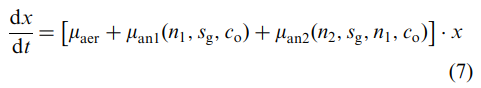

$\frac{dX}{dt} = \left[\mu_{aer}+\mu_{an1} + \mu_{an2}\right]*X$

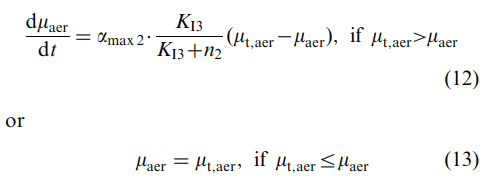

$\frac{d\mu_{aer}}{dt} = \alpha_{max2}*\frac{K_{I3}}{K_{I3}+n_2}(\mu_{t,aer}-\mu_{aer}), if \mu_{t,aer}> \mu_{aer}$  

or:  
$\frac{d\mu_{aer}}{dt} =\mu_{aer} = \mu_{t,aer}, if \mu_{t,aer} <= \mu_{aer}$

$\frac{d\mu_{aer}}{dt} = \alpha*(\mu_{t,aer}-\mu_{aer}), if \mu_{t,aer}> \mu_{aer}$  
or  
$\frac{d\mu_{aer}}{dt} =\mu_{aer} = \mu_{t,aer}, if \mu_{t,aer} <= \mu_{aer}$

$\mu_{t,aer} = \mu_{max}*\frac{s_g}{K_s+s_g}\frac{c_o}{K_o+c_o}\frac{K_{I1}}{K_{I1}+n_1}\frac{K_{I2}}{K_{I2}+n_2}$

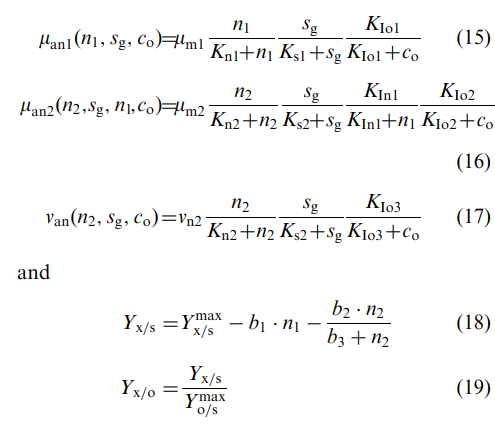

### Simplified model used in class

Oxygen consumption: Monod term  
$r_{O2} = \mu*(C_g/(C_g+K_g))*(C_o/(C_o+K_o))*X$   
Nitrogen consumption: Monod with inhibition term  
$r_{NO3} = \mu*(C_g/(C_g+K_g))*(C_{no3}/(C_{no3}+K_{no3}))*(Ki/(Ki+C_o))*X$  
Nitrite production as byproduct:  
$r_{NO2} = -r_{NO3}$  

Substrate consumption rate (Glutamate)  
$r_s = (1/Y_i)* \sum_i {r_x}^i$


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def f(t,y,
     mu_o2, #max growth rate with O2
     mu_no3, #max growth rate with NO3
     Kg_o, #Half of glutamate concentration for O2
     Kg_no3, #Half concentration for NO3
     Ko, #half concentration of O2
     Kno3, #half concentration for No3
     Ki, #Oxygen inhibiting constant
     Y): # Yield ratios [mg_cell/mM of substrate] for glutamate,oxygen and nitrate
    '''
    Rate function used internally in the ODE solver.
    Computes the rate of change of: Glutamate,O2,NO3,NO2,X(dry mass of cells of bacteria)
    and outputs the rate in array format (in the order above).
    '''
    r = np.zeros(y.shape)
    r[1] = -mu_o2*(y[0]/(y[0]+Kg_o))*(y[1]/(y[1]+Ko))*y[4]/Y[1] #oxygen
    r[2] = -mu_no3*(y[0]/(y[0]+Kg_no3))*(y[2]/(y[2]+Kno3))*(Ki/(Ki+y[1]))*y[4]/Y[2] #NO3
    r[3] = -r[2] #-mu*(y[0]/(y[0]+Kg))*(y[3]/(y[3]+Kno3))*(Ki/(Ki+y[1]))*(Kino3/(Kino3+y[2]))*y[4] #NO2
    r[4] = np.sum(-r[1:3]*Y[1:]) #Biomass
    r[0] =  -r[4]/Y[0]#Glutamate
    
    return r

#### Parameters

In [3]:
y0 = np.array([40,0.22,28,0,50]) #Initial concentrations
mu_o2 = 0.41/3600 #max growth rate with O2
mu_no3 = 0.1/3600 #max growth rate ti NO3
Kg_o = 0.025 #Half concentration for substrate with oxygen
Kg_no3 = 0.05 #Half concentration for substrate with nitrate
Ko = 0.5 #half concentration of oxygen
Kno3 = 0.055 #half concentration of nitrate
Ki = 0.002 #Oxygen inhibition half concentration
Y = np.array([96,44,14]) #Yields


In [4]:
time_intervals = np.arange(0,3600*25,600)

In [5]:
import scipy

In [6]:
results = scipy.integrate.odeint(f,y0,t = time_intervals,args = (mu_o2,mu_no3,Kg_o,Kg_no3,Ko,Kno3,Ki,Y), tfirst = True)

In [7]:
results.shape

(150, 5)

### Compute the rates:

We apply the rate function to the points that we get in our results array.

In [11]:
rates = np.zeros(results.shape)
for i in range(results.shape[0]):
    rates [i,:] = f(time_intervals[i], results[i,:].squeeze(),
     mu_o2,
     mu_no3,
     Kg_o,
     Kg_no3,
     Ko,
     Kno3,
     Ki,
     Y)

### Plot results

#### Concentrations

Text(0.5, 0, 'time [hrs]')

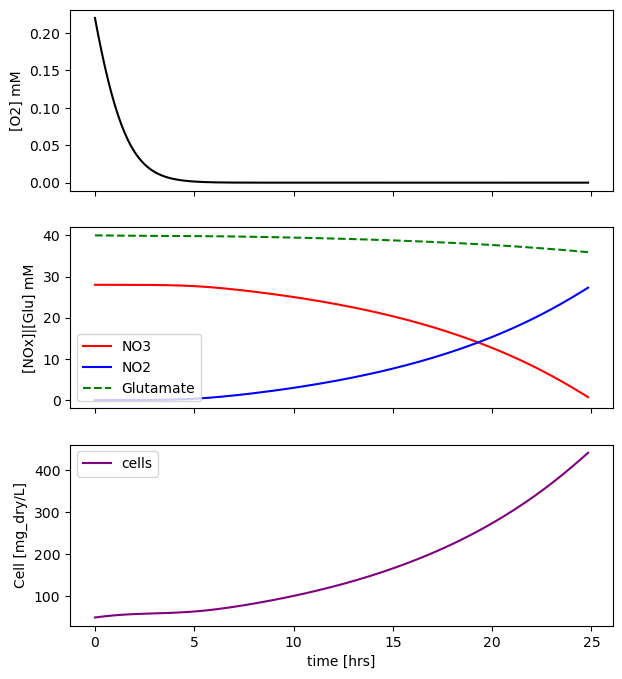

In [9]:
fig, ax = plt.subplots(3,1,figsize = (7,8), sharex = True)
ax[0].plot(time_intervals/3600,results[:,1],'-k')
ax[0].set_ylabel('[O2] mM')
ax[1].plot(time_intervals/3600,results[:,2],'-r', label = 'NO3')
ax[1].plot(time_intervals/3600,results[:,3],'-b', label = 'NO2')
ax[1].plot(time_intervals/3600,results[:,0],'--g', label = 'Glutamate')
ax[1].legend()
ax[1].set_ylabel('[NOx]|[Glu] mM')
ax[2].plot(time_intervals/3600,results[:,4],'-', color = 'purple', label = 'cells')
ax[2].legend()
ax[2].set_ylabel('Cell [mg_dry/L]')
ax[2].set_xlabel('time [hrs]')



#### Rates

Text(0.5, 0, 'time [hrs]')

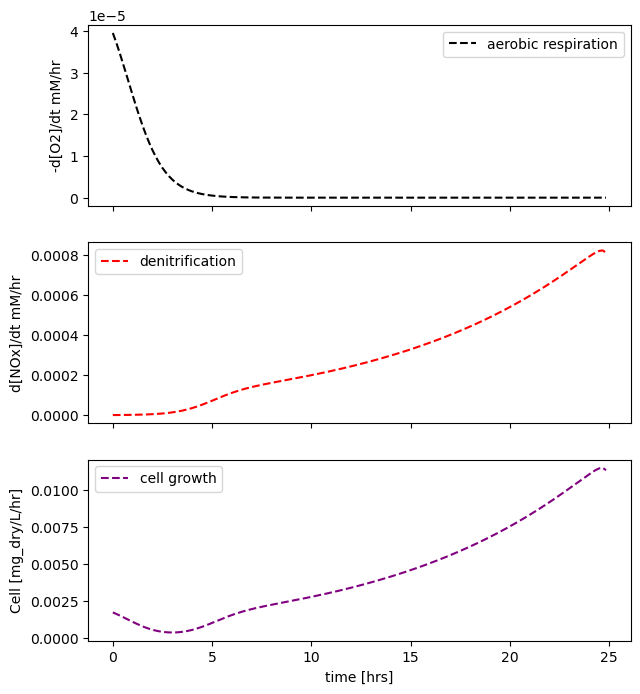

In [14]:
fig, ax = plt.subplots(3,1,figsize = (7,8), sharex = True)
ax[0].plot(time_intervals/3600,-rates[:,1],'--k', label = 'aerobic respiration')
ax[0].legend()
ax[0].set_ylabel('-d[O2]/dt mM/hr')
ax[1].plot(time_intervals/3600,rates[:,3],'--r', label = 'denitrification')
ax[1].legend()
ax[1].set_ylabel('d[NOx]/dt mM/hr')
ax[2].plot(time_intervals/3600,rates[:,4],'--', color = 'purple', label = 'cell growth')
ax[2].legend()
ax[2].set_ylabel('Cell [mg_dry/L/hr]')
ax[2].set_xlabel('time [hrs]')